In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 80

ng =8

ng_adju = (/ 2 /) 

ng_refs = (/ 2 , 6 /) 

nref =2

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 10 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 540

data w_diffuse
     &     /1.9 , 1.7 , 1.4 , 1.4,
     &     1.4 , 1.55 , 1.6 , 1.66/

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.5,
     &     0.5 , 0.5 , 0.5 , 0.5/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

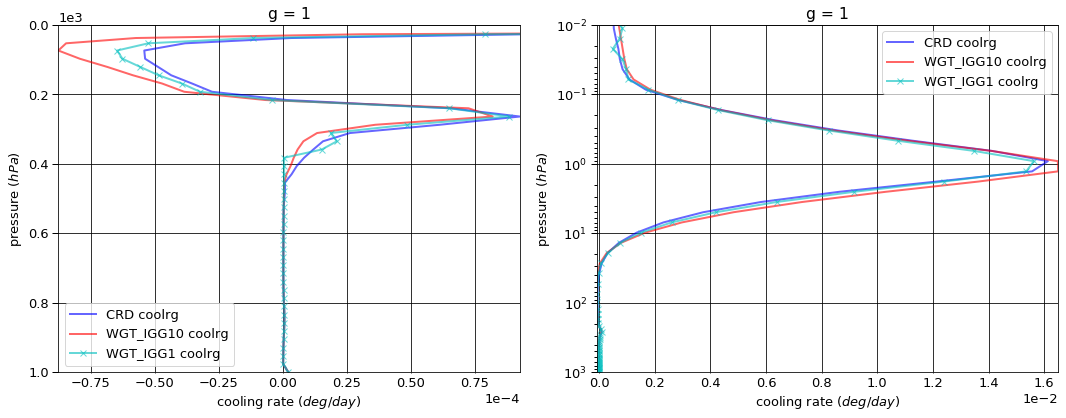

# Figure: cooling rate g-group 2

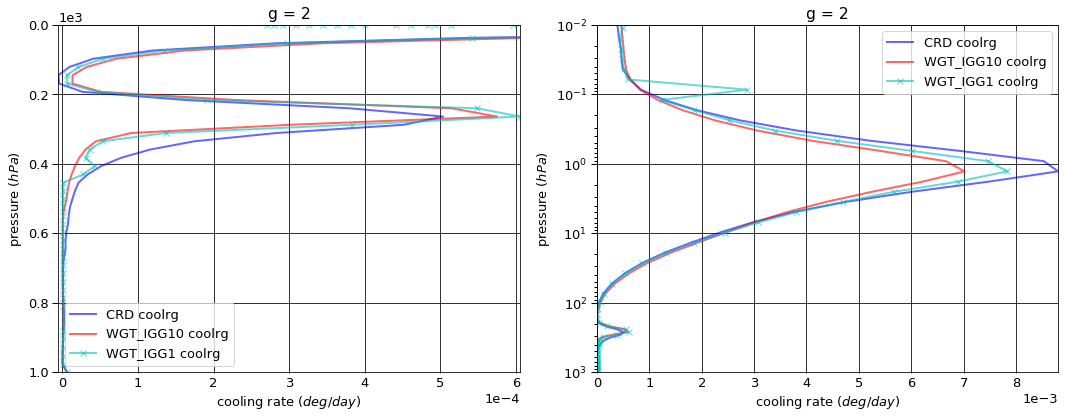

# Figure: cooling rate g-group 3

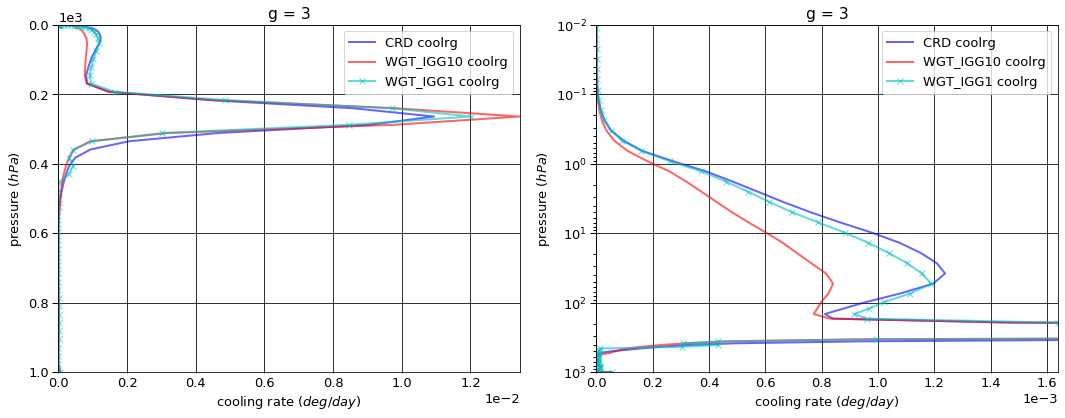

# Figure: cooling rate g-group 4

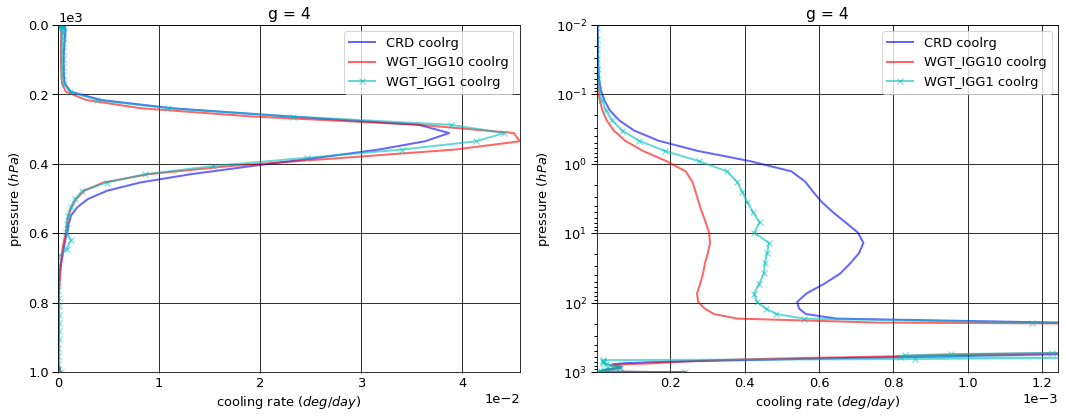

# Figure: cooling rate g-group 5

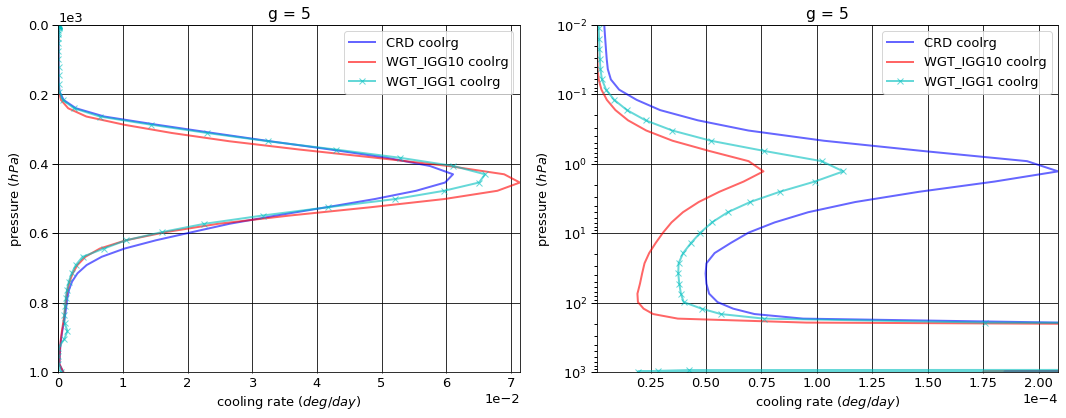

# Figure: cooling rate g-group 6

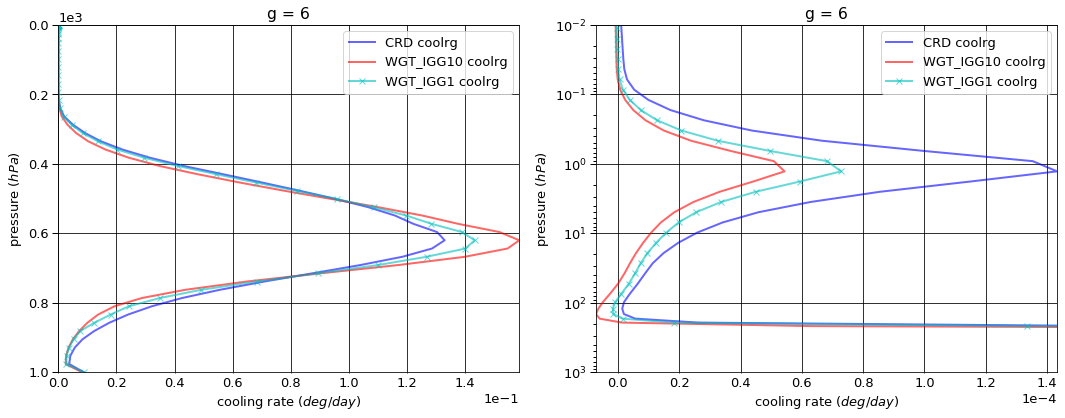

# Figure: cooling rate g-group 7

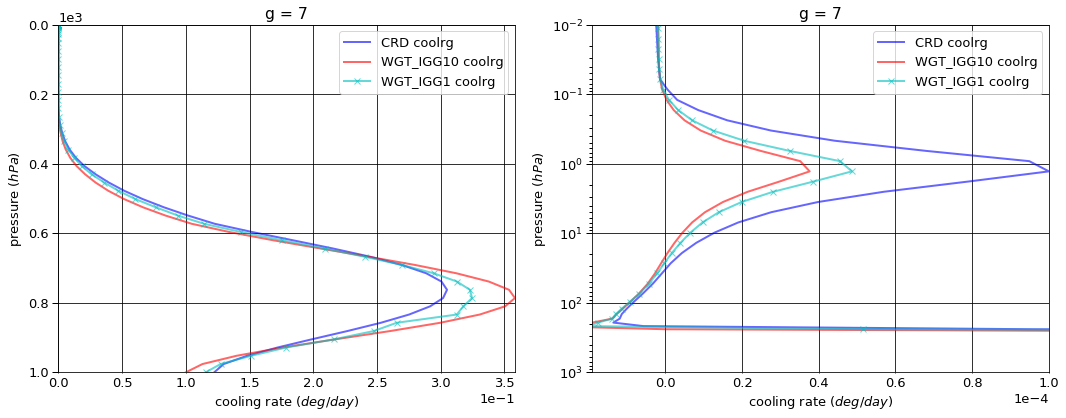

# Figure: cooling rate g-group 8

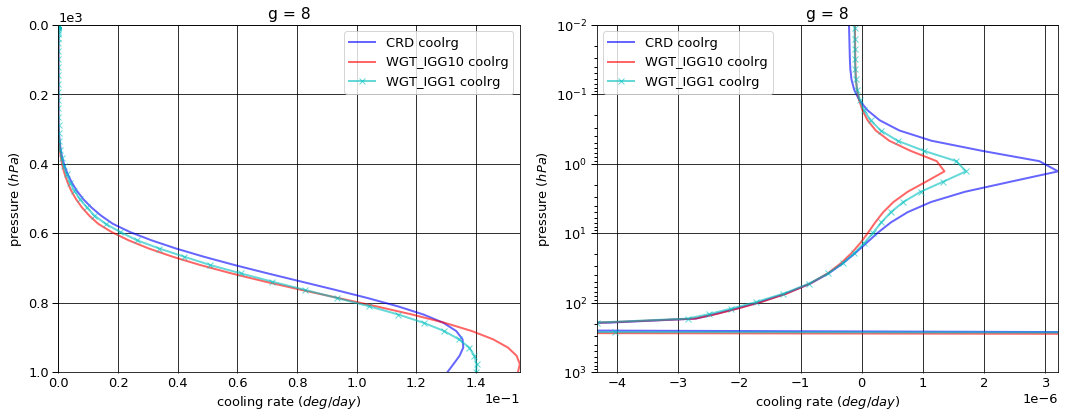

# Figure: cooling rate g-group total

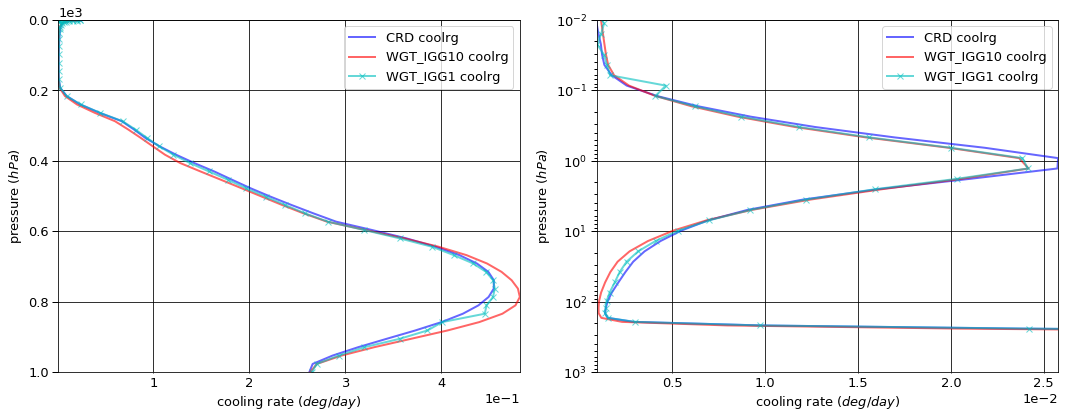

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007397   0.000000  -0.007397
  1013.0   76     -0.013138   0.013132  -0.000006
2 0.0      1      -0.016821   0.000000  -0.016821
  1013.0   76     -0.036699   0.036682  -0.000017
3 0.0      1      -0.143996   0.000000  -0.143996
  1013.0   76     -0.331725   0.331574  -0.000151
4 0.0      1      -0.757052   0.000000  -0.757052
  1013.0   76     -1.463069   1.462404  -0.000665
5 0.0      1      -1.781658   0.000000  -1.781658
  1013.0   76     -2.856111   2.854144  -0.001966
6 0.0      1      -4.999458   0.000000  -4.999458
  1013.0   76     -6.759226   6.732288  -0.026938
7 0.0      1     -13.986707   0.000000 -13.986707
  1013.0   76    -16.419496  15.463413  -0.956083
8 0.0      1      -7.763066   0.000000  -7.763066
  1013.0   76     -8.355945   5.629391  -2.726553


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007676   0.000000  -0.007676
  1013.0   76     -0.013138   0.013132  -0.000006
2 0.0      1      -0.016033   0.000000  -0.016033
  1013.0   76     -0.036699   0.036682  -0.000017
3 0.0      1      -0.143015   0.000000  -0.143015
  1013.0   76     -0.331725   0.331574  -0.000151
4 0.0      1      -0.757931   0.000000  -0.757931
  1013.0   76     -1.463069   1.462404  -0.000665
5 0.0      1      -1.796687   0.000000  -1.796687
  1013.0   76     -2.856111   2.854006  -0.002105
6 0.0      1      -5.014770   0.000000  -5.014770
  1013.0   76     -6.759226   6.736735  -0.022491
7 0.0      1     -14.055064   0.000000 -14.055064
  1013.0   76    -16.419496  15.918582  -0.500913
8 0.0      1      -7.837017   0.000000  -7.837017
  1013.0   76     -8.355945   5.481751  -2.874194


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007452   0.000000  -0.007452
  1013.0   76     -0.013138   0.013132  -0.000006
2 0.0      1      -0.016298   0.000000  -0.016298
  1013.0   76     -0.036699   0.036682  -0.000017
3 0.0      1      -0.141310   0.000000  -0.141310
  1013.0   76     -0.331725   0.331574  -0.000151
4 0.0      1      -0.747586   0.000000  -0.747586
  1013.0   76     -1.463069   1.462404  -0.000665
5 0.0      1      -1.769950   0.000000  -1.769950
  1013.0   76     -2.856111   2.854814  -0.001297
6 0.0      1      -4.987877   0.000000  -4.987877
  1013.0   76     -6.759226   6.734614  -0.024612
7 0.0      1     -14.012813   0.000000 -14.012813
  1013.0   76    -16.419496  15.717556  -0.701939
8 0.0      1      -7.816742   0.000000  -7.816742
  1013.0   76     -8.355945   5.341780  -3.014164


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                      
1 0.0      1     -0.000279  0.000000e+00 -2.792603e-04
  1013.0   76     0.000000 -1.734723e-18 -8.470329e-22
2 0.0      1      0.000788  0.000000e+00  7.879160e-04
  1013.0   76     0.000000  0.000000e+00  0.000000e+00
3 0.0      1      0.000981  0.000000e+00  9.813300e-04
  1013.0   76     0.000000  0.000000e+00  0.000000e+00
4 0.0      1     -0.000879  0.000000e+00 -8.788600e-04
  1013.0   76     0.000000 -2.220446e-16  0.000000e+00
5 0.0      1     -0.015028  0.000000e+00 -1.502820e-02
  1013.0   76     0.000000 -1.383000e-04 -1.382412e-04
6 0.0      1     -0.015312  0.000000e+00 -1.531210e-02
  1013.0   76     0.000000  4.446100e-03  4.446074e-03
7 0.0      1     -0.068357  0.000000e+00 -6.835700e-02
  1013.0   76     0.000000  4.551690e-01  4.551692e-01
8 0.0      1     -0.073951  0.000000e+00 -7.395110e-02
  1013.0   76     0.000000 -1.476408e-01 -1.476408e-01


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                      
1 0.0      1     -0.000055  0.000000e+00 -5.464920e-05
  1013.0   76     0.000000 -1.734723e-18 -8.470329e-22
2 0.0      1      0.000523  0.000000e+00  5.233710e-04
  1013.0   76     0.000000  0.000000e+00  0.000000e+00
3 0.0      1      0.002686  0.000000e+00  2.686000e-03
  1013.0   76     0.000000  0.000000e+00  0.000000e+00
4 0.0      1      0.009466  0.000000e+00  9.466210e-03
  1013.0   76     0.000000 -2.220446e-16  0.000000e+00
5 0.0      1      0.011708  0.000000e+00  1.170800e-02
  1013.0   76     0.000000  6.695000e-04  6.695209e-04
6 0.0      1      0.011581  0.000000e+00  1.158080e-02
  1013.0   76     0.000000  2.325900e-03  2.325830e-03
7 0.0      1     -0.026106  0.000000e+00 -2.610600e-02
  1013.0   76     0.000000  2.541430e-01  2.541435e-01
8 0.0      1     -0.053676  0.000000e+00 -5.367640e-02
  1013.0   76     0.000000 -2.876111e-01 -2.876110e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.049392e-04
  1001.112500 75     2.154514e-06
2 0.000312    1      2.252035e-04
  1001.112500 75     6.022568e-06
3 0.000312    1      8.990728e-09
  1001.112500 75     5.434311e-05
4 0.000312    1      2.808542e-06
  1001.112500 75     2.400204e-04
5 0.000312    1      1.971336e-06
  1001.112500 75     7.738782e-04
6 0.000312    1     -2.886760e-07
  1001.112500 75     8.813225e-03
7 0.000312    1     -3.342997e-06
  1001.112500 75     1.223046e-01
8 0.000312    1     -2.372811e-07
  1001.112500 75     1.304052e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      2.793631e-04
  1001.112500 75     2.154514e-06
2 0.000312    1      3.337374e-04
  1001.112500 75     6.022568e-06
3 0.000312    1      5.716631e-09
  1001.112500 75     5.434311e-05
4 0.000312    1      1.076444e-06
  1001.112500 75     2.400204e-04
5 0.000312    1     -5.643231e-08
  1001.112500 75     8.242390e-04
6 0.000312    1     -1.173941e-06
  1001.112500 75     8.199729e-03
7 0.000312    1     -2.200662e-06
  1001.112500 75     1.000502e-01
8 0.000312    1     -1.225432e-07
  1001.112500 75     1.540852e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.146519e-04
  1001.112500 75     2.154514e-06
2 0.000312    1      2.704416e-04
  1001.112500 75     6.022568e-06
3 0.000312    1      8.816610e-09
  1001.112500 75     5.434311e-05
4 0.000312    1      1.954924e-06
  1001.112500 75     2.400204e-04
5 0.000312    1      5.109499e-07
  1001.112500 75     4.678965e-04
6 0.000312    1     -1.026253e-06
  1001.112500 75     8.672151e-03
7 0.000312    1     -2.392552e-06
  1001.112500 75     1.156152e-01
8 0.000312    1     -1.325580e-07
  1001.112500 75     1.400671e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.744240e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      1.085338e-04
  1001.112500 75     0.000000e+00
3 0.000312    1     -3.274098e-09
  1001.112500 75     0.000000e+00
4 0.000312    1     -1.732098e-06
  1001.112500 75     0.000000e+00
5 0.000312    1     -2.027769e-06
  1001.112500 75     5.036080e-05
6 0.000312    1     -8.852649e-07
  1001.112500 75    -6.134957e-04
7 0.000312    1      1.142336e-06
  1001.112500 75    -2.225444e-02
8 0.000312    1      1.147379e-07
  1001.112500 75     2.368001e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.097128e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      4.523807e-05
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.741182e-10
  1001.112500 75     0.000000e+00
4 0.000312    1     -8.536175e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -1.460386e-06
  1001.112500 75    -3.059817e-04
6 0.000312    1     -7.375767e-07
  1001.112500 75    -1.410740e-04
7 0.000312    1      9.504452e-07
  1001.112500 75    -6.689420e-03
8 0.000312    1      1.047231e-07
  1001.112500 75     9.661890e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.456155,0.00000,-29.456155
1013.0,76,-36.235409,32.52303,-3.712379



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.628193,0.000000,-29.628193
1013.0,76,-36.235409,32.834866,-3.400542



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.500028,0.000000,-29.500028
1013.0,76,-36.235409,32.492557,-3.742851



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.172037,0.000000,-0.172037
1013.0,76,0.000000,0.311836,0.311836



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.043873,0.000000,-0.043873
1013.0,76,0.000000,-0.030473,-0.030472


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000331
1001.112500,75,0.262599



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000611
1001.112500,75,0.263462



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000484
1001.112500,75,0.265125



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000280
1001.112500,75,0.000862



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000153
1001.112500,75,0.002525


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000362,0.000364
2,0.001012,0.001017
3,0.009150,0.009201
4,0.040363,0.040552
5,0.078812,0.079224
6,0.186500,0.187529
7,0.453062,0.454145
8,0.230738,0.227968


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.880119e-19
2,3.156120e-20
3,5.920606e-21
4,1.079701e-21
5,1.968977e-22
6,3.590689e-23
7,6.548096e-24
8,1.194132e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.880119e-19,NaN,0.000362,0.000364,0.000362,0.000364,10.0
2,3.156120e-20,0.167868,0.001012,0.001017,0.001375,0.001381,10.0
3,5.920606e-21,0.187591,0.009150,0.009201,0.010525,0.010583,600.0
4,1.079701e-21,0.182363,0.040363,0.040552,0.050888,0.051134,600.0
5,1.968977e-22,0.182363,0.078812,0.079224,0.129700,0.130358,600.0
6,3.590689e-23,0.182363,0.186500,0.187529,0.316200,0.317887,600.0
7,6.548096e-24,0.182363,0.453062,0.454145,0.769262,0.772032,600.0
8,1.194132e-24,0.182363,0.230738,0.227968,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
